# Preditcting Fraudulent Transaction on a Kaggel Public Dataset

### Load libraries and dataset

In [52]:
import numpy as np
import pandas as pd
from pandas import MultiIndex
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score
from seaborn import heatmap
from seaborn import boxplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [4]:
df = pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
print("Rows: %2d, Columns: %2d" % (df.shape[0], df.shape[1]))

Rows: 6362620, Columns: 11


In [51]:
print("%1.2f%%" %(df["isFraud"].mean()*100))

0.13%


### Identifying missing data

In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

### Heatmap

<AxesSubplot:>

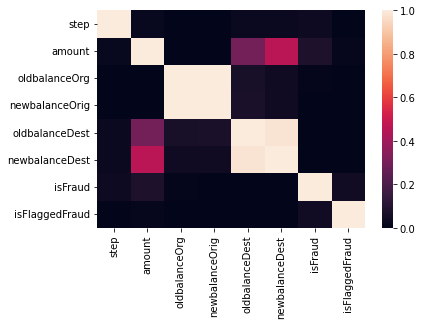

In [7]:
# correlations

df.corr()
heatmap(df.corr(), vmin=0, vmax=1)

### Preparing data for modeling

In [8]:
y = df["isFraud"]
X = df.drop("isFraud", axis = 1)

# Removing identifyers and "step" variable
X = X.drop(["step", "nameDest", "nameOrig", "isFlaggedFraud"], axis=1)

# Create dummies for categorical variables
cat_cols = X.select_dtypes(include=['object']).columns

X = pd.concat([X.drop("type",axis=1), 
            pd.get_dummies(X["type"], 
                           drop_first=True, 
                           prefix_sep="_")],
           axis=1)

### Classificating Fraud

In [9]:
# The following function was coppied from "Putting it all together" Udacity Data Science Nanodegree assignement

def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = coefficients
    coefs_df['abs_coefs'] = np.abs(coefficients)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df


In [63]:
def calculate_auc_pr(X, y, classificator, kfolds, random_state = 42):
    auc_pr = []
    
    kf = KFold(n_splits=kfolds, random_state=random_state, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        clf = classificator.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)
        auc_pr_k = average_precision_score(y_test, y_pred[:,1])
        auc_pr.append(auc_pr_k)
        
    return auc_pr

kfolds = 10
random_state = 42

In [30]:
logistic_auc_pr = calculate_auc_pr(X,y,classificator = LogisticRegression(), kfolds = kfolds, random_state = random_state)

In [31]:
catboost_auc_pr = calculate_auc_pr(X,y,CatBoostClassifier(iterations=100, silent=True), kfolds, random_state = random_state)

In [38]:
xboost_auc_pr = calculate_auc_pr(X,y,XGBClassifier(max_depth=4,n_estimators=100), kfolds, random_state = random_state)

/home/felipe/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/felipe/.local/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:03:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/felipe/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/felipe/.local/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:06:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/felipe/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/felipe/.local/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:10:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/felipe/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/felipe/.local/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:13:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/felipe/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/felipe/.local/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:16:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/felipe/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/felipe/.local/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:19:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/felipe/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/felipe/.local/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:22:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/felipe/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/felipe/.local/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:24:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/felipe/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/felipe/.local/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:27:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/felipe/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/felipe/.local/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:30:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [34]:
print(f"Logistic Regression \nMean: {np.mean(logistic_auc_pr)} Std: {np.std(logistic_auc_pr)}")

Logistic Regression 
Mean: 0.7579029786987215 Std: 0.014676853789921843


In [35]:
print(f"CatBoost \nMean: {np.mean(catboost_auc_pr)} Std: {np.std(catboost_auc_pr)}")

CatBoost 
Mean: 0.9321598617431279 Std: 0.008276898553076378


In [68]:
print(print(f"XGBoost \nMean: {np.mean(xboost_auc_pr)} Std: {np.std(xboost_auc_pr)}"))

XGBoost 
Mean: 0.9409753920569173 Std: 0.00639321121483806
None


In [66]:
boxplot_df = pd.DataFrame()
boxplot_df["auc_pr"] = [*logistic_auc_pr, *catboost_auc_pr, *xboost_auc_pr]
boxplot_df["method"] = [*(["logistic"] * kfolds), *(["catboost"] * kfolds), *(["xgboost"] * kfolds)]
boxplot_df

,auc_pr,method
0,0.772047,logistic
1,0.755922,logistic
2,0.755887,logistic
3,0.750171,logistic
4,0.746486,logistic
5,0.749698,logistic
6,0.755980,logistic
7,0.796426,logistic
8,0.745668,logistic
9,0.750746,logistic


Text(0, 0.5, 'Accuracy Precision')

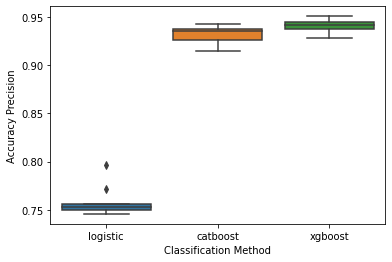

In [72]:
bp = boxplot(x = "method", y = "auc_pr", data = boxplot_df)
bp.set_xlabel("Classification Method")
bp.set_ylabel("Accuracy Precision")